In [1]:
from datetime import datetime, date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [6]:
%%time
# original data
df = pd.read_csv("Flu_3.01.17.csv")
df.AGE_IN_MONTHS = df.AGE_IN_MONTHS.astype(int)

Wall time: 18 s


In [7]:
# date convert function
def date_convert(d):
    vac_date = d[:2] + " " + d[2:5] + " " + d[5:9]
    vac_date = datetime.strptime(vac_date, '%d %b %Y')
    return vac_date

# Apply date convert function to VACCINATION_DATE
updated_dates = df.VACCINATION_DATE.apply(lambda row: date_convert(row))

# convert VACCINATION_DATE column to more useable form
df.VACCINATION_DATE = updated_dates

# drop unnecessary columns
df = df[["ID", "VACCINATION_DATE", "ENTERED_BY_ORG", "AGE_IN_MONTHS"]]

In [8]:
# Group by Year, drop unnecessary columns and add a vacs_administered column
df_annual = df.groupby(df['VACCINATION_DATE'].map(lambda x: x.year)).count()
df_annual['vacs_administered'] = df_annual.ID
df_annual.drop(df_annual.columns[:-1], 1, inplace=True)
df_annual.loc['total', 'vacs_administered'] = df_annual.vacs_administered.sum()

df_annual

,vacs_administered
VACCINATION_DATE,
2009,1389376.0
2010,1732338.0
2011,1832739.0
2012,1924775.0
2013,2161381.0
2014,2053113.0
2015,2063192.0
2016,182670.0
total,13339584.0


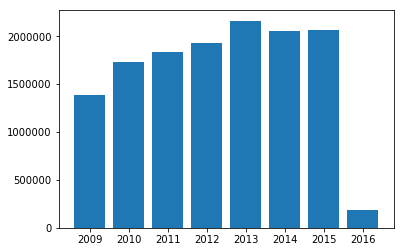

In [6]:
plt.bar(df_annual.index[:8], df_annual.vacs_administered[:8])
plt.show()

In [7]:
# groupby month, rename columns, drop ID column and add a total
df_by_month = df.groupby(by=df['VACCINATION_DATE'].map(
    lambda x: x.month)).count().drop(df.columns[1:], 1)
df_by_month['Vaccines_Administered'] = df_by_month.ID
df_by_month.drop('ID', 1, inplace=True)
df_by_month.loc['total'] = df_by_month.Vaccines_Administered.sum()

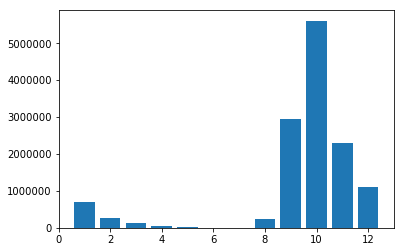

In [8]:
plt.bar(df.index[:12]+1, df_by_month.Vaccines_Administered[:12])
plt.show()

In [9]:
df_months = df.groupby('AGE_IN_MONTHS').count()
df_months.drop(df_months.columns[1:], 1, inplace=True)

In [9]:
def define_flu_season(row):
    month = row.month
    year = row.year
    if month in [7, 8, 9, 10, 11, 12]:
        return year
    elif month in [1, 2, 3, 4, 5, 6]:
        return year-1

In [10]:
df = df.assign(flu_season = df['VACCINATION_DATE'].map(lambda row: define_flu_season(row)))
df = df.assign(VACCINE_COUNT = 1)
df_vaccine_counts = df

In [11]:
# get a transform of vacs per season
vaccines_per_season = df_vaccine_counts.groupby(['ID', 'flu_season'])['VACCINE_COUNT'].transform(np.sum)

# add column to df
df["vaccines_per_season"] = vaccines_per_season

# transform of max_age for season (for purpose of separating into >96m and <= 96m)
df['max_age_for_season'] = df.groupby(['ID', 'flu_season'])["AGE_IN_MONTHS"].transform(max)

# add appropriate column; will change this to false pending on results of below queries
df['appropriate'] = True

# add a unique clinics column
df['nunique_clinics_per_season'] = df.groupby(['ID', 'flu_season'])['ENTERED_BY_ORG'].transform(pd.Series.nunique)

# start with those age > 96
older_than_96 = df[df.max_age_for_season > 96]

# those <= 96
younger_than_96 = df[df.max_age_for_season <= 96]

In [68]:
# takes approximately 1 hour
%%time
inapp_vac_indices = []
total_count = 0
for ID, vacs in older_than_96[].groupby('ID'):
    
    # printed output to track progress
    total_count += 1
    if total_count % 10000 == 0:
        print("Count: ", total_count)
    
    # find multi_vac seasons
    inapp_vacs = vacs[vacs.vaccines_per_season > 1]
    
    # no multi_vac seasons
    if len(inapp_vacs) < 1:
        continue
    
    season_counts = inapp_vacs['flu_season'].value_counts()
    
    for season in season_counts.index:
        # number of vacs in given multi vac season
        count = int(season_counts[season])
        
        # offset by one vac, as they can have one vac per season
        inapp_indices = list(inapp_vacs[inapp_vacs.flu_season == season][1:count].index)
        
        for ind in inapp_indices:
            inapp_vac_indices.append(int(ind))

Count:  10000
Count:  20000
Count:  30000
Count:  40000
Count:  50000
Count:  60000
Count:  70000
Count:  80000
Count:  90000
Count:  100000
Count:  110000
Count:  120000
Count:  130000
Count:  140000
Count:  150000
Count:  160000
Count:  170000
Count:  180000
Count:  190000
Count:  200000
Count:  210000
Count:  220000
Count:  230000
Count:  240000
Count:  250000
Count:  260000
Count:  270000
Count:  280000
Count:  290000
Count:  300000
Count:  310000
Count:  320000
Count:  330000
Count:  340000
Count:  350000
Count:  360000
Count:  370000
Count:  380000
Count:  390000
Count:  400000
Count:  410000
Count:  420000
Count:  430000
Count:  440000
Count:  450000
Count:  460000
Count:  470000
Count:  480000
Count:  490000
Count:  500000
Count:  510000
Count:  520000
Count:  530000
Count:  540000
Count:  550000
Count:  560000
Count:  570000
Count:  580000
Count:  590000
Count:  600000
Count:  610000
Count:  620000
Count:  630000
Count:  640000
Count:  650000
Count:  660000
Count:  670000
Coun

In [12]:
# save indices in a spread sheet
inapp_vac_indices_array = np.array(inapp_vac_indices)
older_inapp_vac_indices_series = pd.Series(data=inapp_vac_indices_array, name="older_inapp_vac_indices")
older_inapp_vac_indices_series.to_csv("older_inapp_vac_indices.csv")

NameError: name 'inapp_vac_indices' is not defined

In [ ]:
# get ids of inapp vacs in this dataset 
older_ids = list(set(older_than_96[older_than_96.index.isin(inapp_vac_indices)]['ID'].values))

In [ ]:
# filter only appropriate vacs for those older_than_96 (i.e. those not labeled as inappropriate)
good_vacs = older_than_96[~older_than_96.index.isin(inapp_vac_indices)]

# group on ID and flu season, summing on vac count
good_grouped = good_vacs.groupby(['ID', 'flu_season']).agg({'VACCINE_COUNT' : np.sum})

# make sure there are none > 1; below should not return any entries
good_grouped[good_grouped.VACCINE_COUNT > 1]

In [ ]:
# filter only inappropriate vacs (i.e. those labeled as inappropriate)
bad_vacs = older_than_96[older_than_96.index.isin(inapp_vac_indices)]

# there should be no seasons with more than 1 vac; the below should not return any entries
bad_vacs[bad_vacs.vaccines_per_season < 2]

In [185]:
%%time
# should take approximately 10 minutes
# good test df for final condition
# test = younger_than_96[(younger_than_96.ID == 367843) | (younger_than_96.ID == 402712) | 
#                 (younger_than_96.ID == 734909)]

only_one_IDs = []
correct_IDs = []
inappropriate_vacs_one_mult_inds = []
inappropriate_vacs_mult_mult_inds = []
inappropriate_vacs_one_mult_ids = []
inappropriate_vacs_mult_mult_ids = []
missed_vacs = []

# replace test with younger_than_96
for ID, vacs in younger_than_96.groupby('ID'):
    max_count = vacs.vaccines_per_season.max()
    if max_count > 1: 
        vac_counts_per_season = vacs.flu_season.value_counts()
        multi_vac_seasons = vac_counts_per_season[vac_counts_per_season > 1].sort_index()
        # do you need values here??
        n_mult_vac_seasons = len(multi_vac_seasons)
    
    
    # never received 2 vacs
    if max_count < 2:
        only_one_IDs.append(ID)
        continue
        
    # 2 vacs received in only one season
    if max_count == 2 and n_mult_vac_seasons == 1:
        correct_IDs.append(ID)
        continue

    # more than 2 vacs in only one season
    if max_count > 2 and n_mult_vac_seasons == 1:
        # append ID
        inappropriate_vacs_one_mult_ids.append(ID)
        
        multi_vac_season = multi_vac_seasons.index[0]
        
        # go from index 2 to index num_vacs given one incidence of 2 vacs is appropriate
        indices = list(vacs[vacs.flu_season == multi_vac_season][2:].index)
        for ind in indices:
            inappropriate_vacs_one_mult_inds.append(int(ind))
        continue
    
    # >= 2 vacs in more than one season
    if max_count >= 2 and n_mult_vac_seasons > 1:
        inappropriate_vacs_mult_mult_ids.append(ID)

        first_mult_season = multi_vac_seasons.index[0]
        first_mult_season_vacs = vacs[vacs.flu_season == first_mult_season]
        
        # for the first season: count the first two vaccines as appropriate, everything after as bad
        if len(first_mult_season_vacs) > 2: 
            bad_vac_indices = first_mult_season_vacs[2:].index
            for ind in bad_vac_indices:
                inappropriate_vacs_mult_mult_inds.append(int(ind))
        
        # for the next seasons: count everything after 1 vac as bad
        for season in multi_vac_seasons.index[1:]:
            season_vacs = vacs[vacs.flu_season == season]
            bad_vac_indices = season_vacs.index[1:]
            for ind in bad_vac_indices:
                inappropriate_vacs_mult_mult_inds.append(int(ind))
        continue
    
    # Quality control: this should have length of 0
    else:
        print("MISSED VAC: ", ID)
        missed_vacs.append(ID)

Wall time: 8min 16s


In [246]:
# save indices and ids in a spreadsheet
younger_only_one_ids = pd.Series(data=only_one_IDs, name="younger_only_one_ids")
younger_only_one_ids.to_csv("younger_only_one_ids.csv")

younger_correct_ids = pd.Series(data=correct_IDs, name="younger_correct_ids")
younger_correct_ids.to_csv("younger_correct_ids.csv")

younger_inappropriate_vacs_one_mult_inds = pd.Series(data=inappropriate_vacs_one_mult_inds, name="younger_inappropriate_vacs_one_mult_inds")
younger_inappropriate_vacs_one_mult_inds.to_csv("younger_inappropriate_vacs_one_mult_inds.csv")

younger_inappropriate_vacs_mult_mult_inds = pd.Series(data=inappropriate_vacs_mult_mult_inds, name="younger_inappropriate_vacs_mult_mult_inds")
younger_inappropriate_vacs_mult_mult_inds.to_csv("younger_inappropriate_vacs_mult_mult_inds.csv")

younger_one_mult_ids = pd.Series(data=inappropriate_vacs_one_mult_ids, name="younger_inappropriate_vacs_one_mult_ids")
younger_one_mult_ids.to_csv("younger_inappropriate_vacs_one_mult_ids.csv")

younger_mult_mult_ids = pd.Series(data=inappropriate_vacs_mult_mult_ids, name="inappropriate_vacs_mult_mult_ids")
younger_mult_mult_ids.to_csv("younger_mult_mult_ids.csv")

In [73]:
%%time
# jump into analysis here w/o having to recalculate all the values
# fully analyzed data w/ appropriate column
# import this and set it to df to do the analysis below
df_analyzed = pd.read_csv("vaccines_with_appropriate_column.csv")
df = df_analyzed

# data to load
only_one_ids = pd.read_csv("younger_only_one_ids.csv", header=None)
correct_IDs = pd.read_csv("younger_correct_ids.csv", header=None)
inappropriate_vacs_one_mult_inds = pd.read_csv("younger_inappropriate_vacs_one_mult_inds.csv", header=None)
inappropriate_vacs_mult_mult_inds = pd.read_csv("younger_inappropriate_vacs_mult_mult_inds.csv", header=None)
inappropriate_vacs_one_mult_ids = pd.read_csv("younger_inappropriate_vacs_one_mult_ids.csv", header=None)
inappropriate_vacs_mult_mult_ids = pd.read_csv("younger_mult_mult_ids.csv", header=None)
inapp_vac_indices = pd.read_csv("older_inapp_vac_indices.csv", header=None)

# convert imported ids and inds to lists
only_one_IDs = only_one_ids[1].values.tolist()
correct_IDs = correct_IDs[1].values.tolist()
inappropriate_vacs_one_mult_inds = inappropriate_vacs_one_mult_inds[1].values.tolist()
inappropriate_vacs_mult_mult_inds = inappropriate_vacs_mult_mult_inds[1].values.tolist()
inappropriate_vacs_one_mult_ids = inappropriate_vacs_one_mult_ids[1].values.tolist()
inappropriate_vacs_mult_mult_ids = inappropriate_vacs_mult_mult_ids[1].values.tolist()
inapp_vac_indices = inapp_vac_indices[1].values.tolist()

# redefine age > 96m df
older_than_96 = df[df.max_age_for_season > 96]

# those <= 96
younger_than_96 = df[df.max_age_for_season <= 96]

Wall time: 15.6 s


In [43]:
# only one test
only_one_df = younger_than_96[younger_than_96.ID.isin(only_one_IDs)]
only_one_df[only_one_df.vaccines_per_season > 1]

,Unnamed: 0,ID,VACCINATION_DATE,ENTERED_BY_ORG,AGE_IN_MONTHS,flu_season,VACCINE_COUNT,vaccines_per_season,max_age_for_season,appropriate,nunique_clinics_per_season


In [44]:
# correct_IDs test
# can count the number of two vac season in the correct IDs w/ a group by and count
correct_ids_df = younger_than_96[younger_than_96.ID.isin(correct_IDs)]
correct_ids_df_grouped = correct_ids_df.groupby(['ID', 'flu_season']).agg({'VACCINE_COUNT' : np.sum})
mult_vac_seasons = correct_ids_df_grouped[correct_ids_df_grouped.VACCINE_COUNT > 1]

# test that list of all unique ids in mult vac seasons > 1 are equal to the len of original df
ids = []
for ind in mult_vac_seasons.index:
    ids.append(ind[0])
ids = set(ids)
ids = list(ids)

# only one ID per season => success
len(ids) == mult_vac_seasons.shape[0]

True

In [45]:
# test for one_mult_vacs
# can count the number of multi vac seasons w/ a group by
# make sure there is only one
# then make sure there is > 2 vacs in that season

one_mult_vac_df = younger_than_96[younger_than_96.ID.isin(inappropriate_vacs_one_mult_ids)]
one_mult_vac_df_grouped = one_mult_vac_df.groupby(['ID', 'flu_season']).agg({'VACCINE_COUNT' : np.sum})
mult_vac_seasons = one_mult_vac_df_grouped[one_mult_vac_df_grouped.VACCINE_COUNT > 1]

# test that list of all unique ids in mult vac seasons > 1 are equal to the len of that df
ids = []
for ind in mult_vac_seasons.index:
    ids.append(ind[0])
ids = set(ids)
ids = list(ids)

# only one ID per season => success
len(ids) == mult_vac_seasons.shape[0]

True

In [46]:
# test for mult_mult vacs
# maybe just eyeball this one, not good way of grouping this right now
mult_mult_vac_df = younger_than_96[younger_than_96.ID.isin(inappropriate_vacs_mult_mult_ids)]
mult_mult_vac_df_grouped = mult_mult_vac_df.groupby(['ID', 'flu_season']).agg({'VACCINE_COUNT' : np.sum})
mult_vac_seasons = mult_mult_vac_df_grouped[mult_mult_vac_df_grouped.VACCINE_COUNT > 1]

mult_vac_seasons

ids = []
for ind in mult_vac_seasons.index:
    ids.append(ind[0])
    
from collections import Counter

# no mistake
count = Counter(ids)
for value in count.values():
    if value < 2:
        print("MISTAKE")

In [47]:
# update original df's vaccines based on appropriateness
df.loc[df.index.isin(inapp_vac_indices), "appropriate"] = False
df.loc[df.index.isin(inappropriate_vacs_one_mult_inds), "appropriate"] = False
df.loc[df.index.isin(inappropriate_vacs_mult_mult_inds), "appropriate"] = False



In [48]:
# update age subgroups
younger_than_96.loc[younger_than_96.index.isin(inappropriate_vacs_mult_mult_inds), "appropriate"] = False
younger_than_96.loc[younger_than_96.index.isin(inappropriate_vacs_one_mult_inds), "appropriate"] = False
older_than_96.loc[older_than_96.index.isin(inapp_vac_indices), "appropriate"] = False

C:\Users\samko\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [49]:
# lengths match up; no errors raised
assert younger_than_96[younger_than_96.appropriate == False].shape[0] == len(inappropriate_vacs_one_mult_inds) + len(inappropriate_vacs_mult_mult_inds)
assert len(inapp_vac_indices) == older_than_96[older_than_96.appropriate==False].shape[0]
assert (len(inapp_vac_indices) + 
 len(inappropriate_vacs_one_mult_inds) + 
 len(inappropriate_vacs_mult_mult_inds)) == df[df.appropriate == False].shape[0]

In [376]:
# save updated csv to df
df.to_csv("vaccines_with_appropriate_column.csv")

In [50]:
# summary statistics for original df
print("Dataset total num of IDs: ", df.ID.nunique())
print("Dataset total num IDs with bad vacs: ", df[df.appropriate == False].ID.nunique())
print("Dataset percent ID's w/ bad vacs : ", "{:.4f}%".format(271579 / 4137453 * 100))
print("Dataset total num vaccines: ", df.shape[0])
print("Dataset total num inapp vacs: ", df[df.appropriate == False].shape[0])
print("Dataset total num : ", "{:.4f}%".format(324113 / 13339584 * 100))

Dataset total num of IDs:  4137453
Dataset total num IDs with bad vacs:  271579
Dataset percent ID's w/ bad vacs :  6.5639%
Dataset total num vaccines:  13339584
Dataset total num inapp vacs:  324113
Dataset total num :  2.4297%


In [51]:
# age <= 96 summary statistics
print("Age<=96 total num of IDs: ", younger_than_96.ID.nunique())
print("Age<=96 total num IDs with bad vacs: ", younger_than_96[younger_than_96.appropriate == False].ID.nunique())
print("Age<=96 percent ID's w/ bad vacs : ", "{:.4f}%".format(11793 / 796128 * 100))
print("Age<=96 total num vaccines: ", younger_than_96.shape[0])
print("Age<=96 total num inapp vacs: ", younger_than_96[younger_than_96.appropriate == False].shape[0])
print("Age<=96 total num : ", "{:.4f}%".format(12661 / 2340691 * 100))

Age<=96 total num of IDs:  796128
Age<=96 total num IDs with bad vacs:  11793
Age<=96 percent ID's w/ bad vacs :  1.4813%
Age<=96 total num vaccines:  2340691
Age<=96 total num inapp vacs:  12661
Age<=96 total num :  0.5409%


In [52]:
# age > 96m summary statistics 
print("Age>96 total num of IDs: ", older_than_96.ID.nunique())
print("Age>96 total num IDs with bad vacs: ", older_than_96[older_than_96.appropriate == False].ID.nunique())
print("Age>96 percent ID's w/ bad vacs : ", "{:.4f}%".format(259824 / 3519982 * 100))
print("Age>96 total num vaccines: ", older_than_96.shape[0])
print("Age>96 total num inapp vacs: ", older_than_96[older_than_96.appropriate == False].shape[0])
print("Age>96 total num : ", "{:.4f}%".format(311452 / 10998893 * 100))

Age>96 total num of IDs:  3519982
Age>96 total num IDs with bad vacs:  259824
Age>96 percent ID's w/ bad vacs :  7.3814%
Age>96 total num vaccines:  10998893
Age>96 total num inapp vacs:  311452
Age>96 total num :  2.8317%


In [53]:
# filter only bad vacs
bad_vacs = df[df.appropriate == False]
bad_vac_ids = df[df.appropriate == False]['ID']

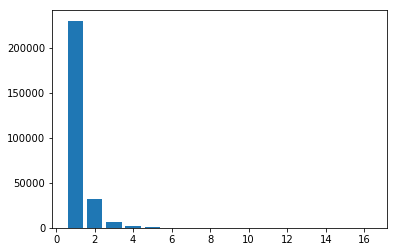

,VACCINE_COUNT
1,230455
2,32489
3,6551
4,1558
5,413
6,85
7,19
8,4
9,2
10,1


In [54]:
# histogram of the number of bad vacs each individual received since 2009
bad_vac_counts = bad_vacs.groupby('ID').agg({"VACCINE_COUNT" : np.sum})["VACCINE_COUNT"].value_counts().sort_index()
plt.bar(left=bad_vac_counts.index, height=bad_vac_counts)
plt.show()
bad_vac_counts.to_frame()

In [55]:
bad_vac_counts[1:].sum() 
1 - 41124 / 271579

0.8485744479506884

In [82]:
# there are 2009 total clinics
clinic_value_counts = bad_vacs.ENTERED_BY_ORG.value_counts().to_frame()
clinic_value_counts['percent_total_bad_vacs'] = clinic_value_counts.ENTERED_BY_ORG / len(bad_vacs) * 100

# top 10 clinics and their percentage of their bad vacs
print("Percent (%) top 10 accounted for: ", clinic_value_counts[:10].percent_total_bad_vacs.sum())

Percent (%) top 10 accounted for:  30.313193238160764


In [62]:
# this column was created in type object for some reason...
bad_vacs.loc[:, "nunique_clinics_per_season"] = bad_vacs.nunique_clinics_per_season.astype(int)

C:\Users\samko\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [64]:
bad_vacs_grouped = bad_vacs.groupby(['ID', 'flu_season']).agg({"VACCINE_COUNT" : np.sum, "nunique_clinics_per_season" : np.mean})

In [67]:
# of those who had 1 bad vac, how many unique clinics did they go to that season?
# note you can have 3 given those <=96 can get two vacs
num_clinics_1_vac = bad_vacs_grouped[bad_vacs_grouped.VACCINE_COUNT == 1]['nunique_clinics_per_season'].value_counts().sort_index().to_frame()
num_clinics_1_vac.rename(columns={"nunique_clinics_per_season" : "one_bad_vac_seasons"}, inplace=True)

# of those who had 2 bad vacs, how many unique clinics did they go to that season?
num_clinics_2_vacs = bad_vacs_grouped[bad_vacs_grouped.VACCINE_COUNT == 2]['nunique_clinics_per_season'].value_counts().sort_index().to_frame()
num_clinics_2_vacs.rename(columns={"nunique_clinics_per_season" : "two_bad_vac_seasons"}, inplace=True)

# of those who had 3 bad vacs, how many unique clinics did they go to that season?
num_clinics_3_vacs = bad_vacs_grouped[bad_vacs_grouped.VACCINE_COUNT == 3]['nunique_clinics_per_season'].value_counts().sort_index().to_frame()
num_clinics_3_vacs.rename(columns={"nunique_clinics_per_season" : "three_bad_vac_seasons"}, inplace=True)

# of those who had 4 bad vacs, how many unique clinics did they go to that season?
num_clinics_4_vacs = bad_vacs_grouped[bad_vacs_grouped.VACCINE_COUNT == 4]['nunique_clinics_per_season'].value_counts().sort_index().to_frame()
num_clinics_4_vacs.rename(columns={"nunique_clinics_per_season" : "four_bad_vac_seasons"}, inplace=True)

# of those who had 5 bad vacs, how many unique clinics did they go to that season?
num_clinics_5_vacs = bad_vacs_grouped[bad_vacs_grouped.VACCINE_COUNT >= 5]['nunique_clinics_per_season'].value_counts().sort_index().to_frame()
num_clinics_5_vacs.rename(columns={"nunique_clinics_per_season" : "more_than_5"}, inplace=True)

clinic_df = pd.merge(num_clinics_1_vac, num_clinics_2_vacs, how="outer", right_index=True, left_index=True)
clinic_df = pd.merge(clinic_df, num_clinics_3_vacs, how="outer", right_index=True, left_index=True)  
clinic_df = pd.merge(clinic_df, num_clinics_4_vacs, how="outer", right_index=True, left_index=True)  
clinic_df = pd.merge(clinic_df, num_clinics_5_vacs, how="outer", right_index=True, left_index=True) 
clinic_df.fillna(0, inplace=True)

clinic_df.index.rename("Number of Unique Clinics", inplace=True)
clinic_df

,one_bad_vac_seasons,two_bad_vac_seasons,three_bad_vac_seasons,four_bad_vac_seasons,more_than_5
Number of Unique Clinics,,,,,
1,39027.0,406.0,38.0,4.0,4.0
2,274483.0,2225.0,51.0,1.0,0.0
3,191.0,2339.0,25.0,2.0,1.0
4,0.0,0.0,18.0,0.0,1.0
5,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,1.0


In [69]:
bad_vacs_per_season = bad_vacs.groupby('flu_season').agg({"VACCINE_COUNT" : np.sum})

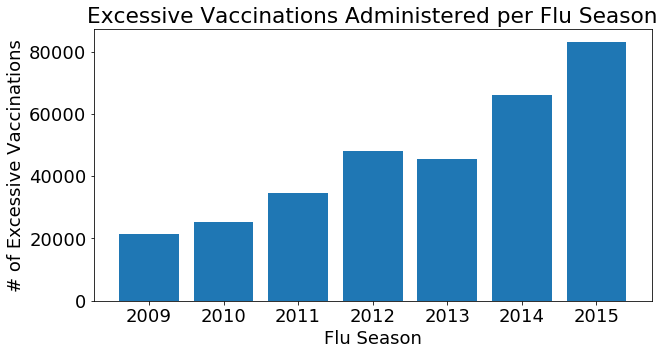

In [70]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

# this seems to reset the font settings for all of matplotlib
# look into this more
plt.rc('font', **font)

plt.figure(figsize=(10,5))
plt.bar(left=bad_vacs_per_season.index, height=bad_vacs_per_season.values)
plt.title("Excessive Vaccinations Administered per Flu Season")
plt.xlabel("Flu Season")
plt.ylabel("# of Excessive Vaccinations")
plt.show()
plt.rcdefaults()

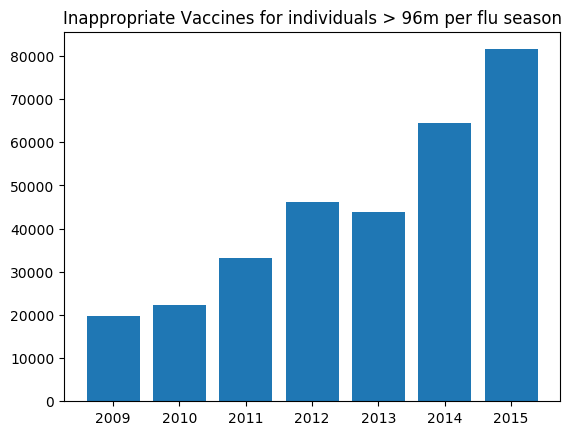

In [71]:
inapp_vacs_per_season_old = older_than_96[older_than_96.index.isin(inapp_vac_indices)].groupby('flu_season').agg({'VACCINE_COUNT' : np.sum})
plt.bar(left=inapp_vacs_per_season_old.index, height=inapp_vacs_per_season_old.values)
plt.title("Inappropriate Vaccines for individuals > 96m per flu season")
plt.show()

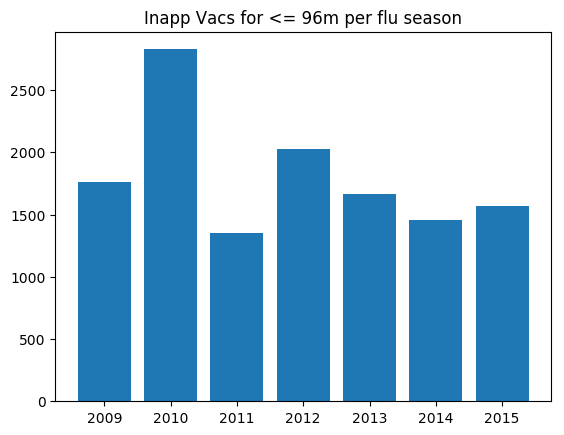

In [75]:
inapp_young_vac_inds = inappropriate_vacs_one_mult_inds + inappropriate_vacs_mult_mult_inds
inapp_young_vac_df = younger_than_96[younger_than_96.index.isin(inapp_young_vac_inds)]
inapp_vacs_per_season_young = inapp_young_vac_df.groupby('flu_season').agg({'VACCINE_COUNT' : np.sum})
plt.bar(left=inapp_vacs_per_season_young.index, height=inapp_vacs_per_season_young.values)
plt.title("Inapp Vacs for <= 96m per flu season")
plt.show()

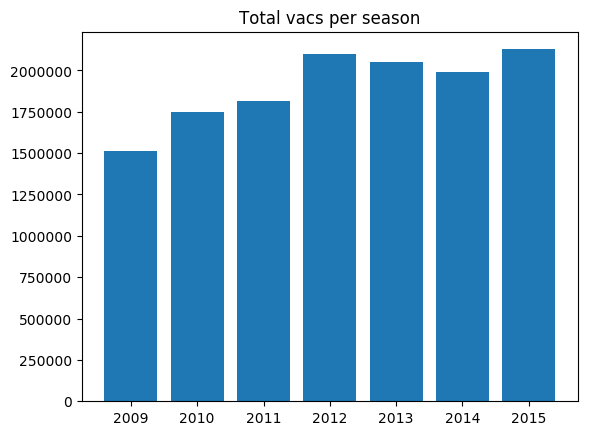

In [76]:
# Vaccines per flu season
vacs_per_season = df.groupby('flu_season').agg({"VACCINE_COUNT" : np.sum})
plt.bar(left=vacs_per_season.index, height=vacs_per_season.values)
plt.title("Total vacs per season")
plt.show()

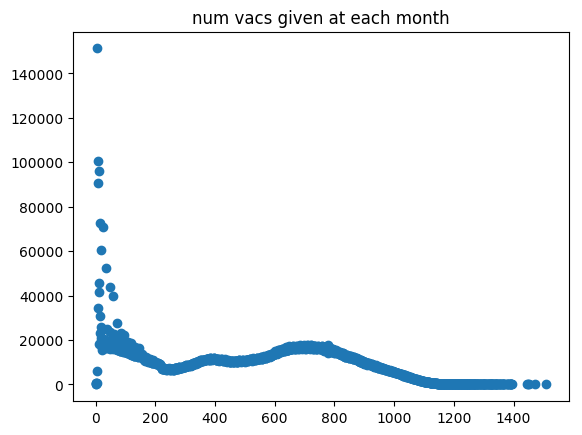

In [77]:
agg_vacs_at_each_month = df.groupby('AGE_IN_MONTHS').agg({"VACCINE_COUNT" : np.sum})
plt.scatter(x=agg_vacs_at_each_month.index, y=agg_vacs_at_each_month.values)
plt.title("num vacs given at each month")
plt.show()

In [483]:
age_counts = {}
for x in range(0, df.AGE_IN_MONTHS.max(), 12):
    skip = x+12
    counts = df[(df.AGE_IN_MONTHS > x) & (df.AGE_IN_MONTHS <= skip)].shape[0]
    age_counts[skip] = counts

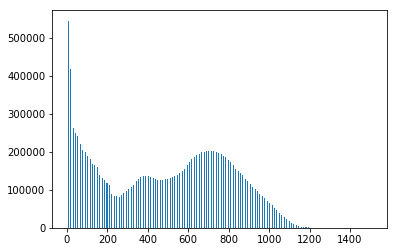

In [509]:
plt.bar(left=list(age_counts.keys()), height=list(age_counts.values()), width=5)
plt.show()

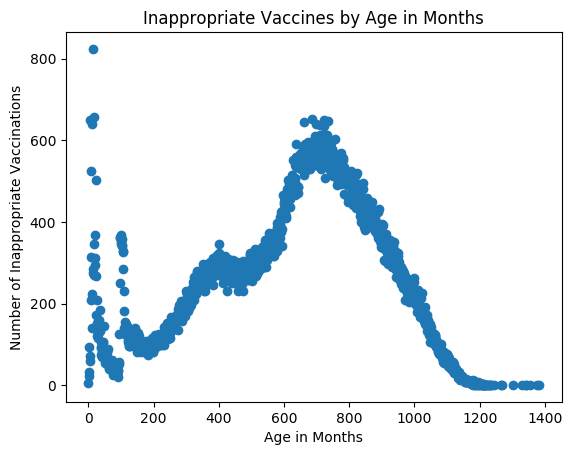

In [80]:
bad_vacs_by_age = bad_vacs.groupby('AGE_IN_MONTHS').agg({"VACCINE_COUNT" : np.sum})
plt.scatter(x=bad_vacs_by_age.index, y=bad_vacs_by_age.values)
plt.title("Inappropriate Vaccines by Age in Months")
plt.xlabel("Age in Months")
plt.ylabel("Number of Inappropriate Vaccinations")
plt.show()

In [81]:
bad_vacs_by_age[650:750]['VACCINE_COUNT'].argmax()

687